<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

---

A common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. 

Try your best to tune your model. It can be difficult, but don't worry - timeseries analysis is just a difficult and specialised topic.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm

np.set_printoptions(precision=4)
sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [2]:
# get the dataset
data = pd.read_csv('../../../../../resource-datasets/walmart_stores/train.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True, drop=True)
data.index.name = None
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [3]:
data.dtypes

Store             int64
Dept              int64
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [4]:
data.index.dtype

dtype('<M8[ns]')

## Look back at the lesson notes for information about these models and acf/pacf plots

- [1. Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.](#filter)
- [2. Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?](#rolling)
- [3. Compute the 1, 2, 52 autocorrelations for `Weekly_Sales` and create an autocorrelation and partial autocorrelation plot.](#acf)
- [4. *BONUS:* What do the acf() and pacf() plots say about the type of model you want to build?](#interpretation)
- [5. Split the weekly sales data in a training and test set - using 75% of the data for training.](#train-test)
- [6. "Difference" the data by converting the sales into change in sales (diff function is convenient for doing this.)](#diff)
- [7. Fit an AR(1) model on the training data and compute the mean squared error of the predictions. How effective is this model?](#AR1)
- [8. Plot the residuals - where are their significant errors?](#residuals)
- [9. Fit an AR(2) model and an ARMA(2, 2) model - does this improve your mean squared error on the held out set?](#AR2)
- [10. Assemble your findings including any useful graphs.](#summary)

### 1. Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.
<a id='filter'></a>

In [5]:
store1 = data[data.Store == 1]
# there are about 36 different stores in this dataset.

In [6]:
# Grouped weekly sales by store 1
store1_sales = store1[['Weekly_Sales']].resample('W').sum()

In [7]:
store1_sales.dtypes

Weekly_Sales    float64
dtype: object

In [8]:
store1_sales.head()

,Weekly_Sales
2010-02-07,1643690.90
2010-02-14,1641957.44
2010-02-21,1611968.17
2010-02-28,1409727.59
2010-03-07,1554806.68


### 2. Plot the rolling_mean for Weekly_Sales. What general trends do you observe?
<a id='rolling'></a>

In [9]:
store1_sales.rolling(window=1).mean().head()

,Weekly_Sales
2010-02-07,1643690.90
2010-02-14,1641957.44
2010-02-21,1611968.17
2010-02-28,1409727.59
2010-03-07,1554806.68


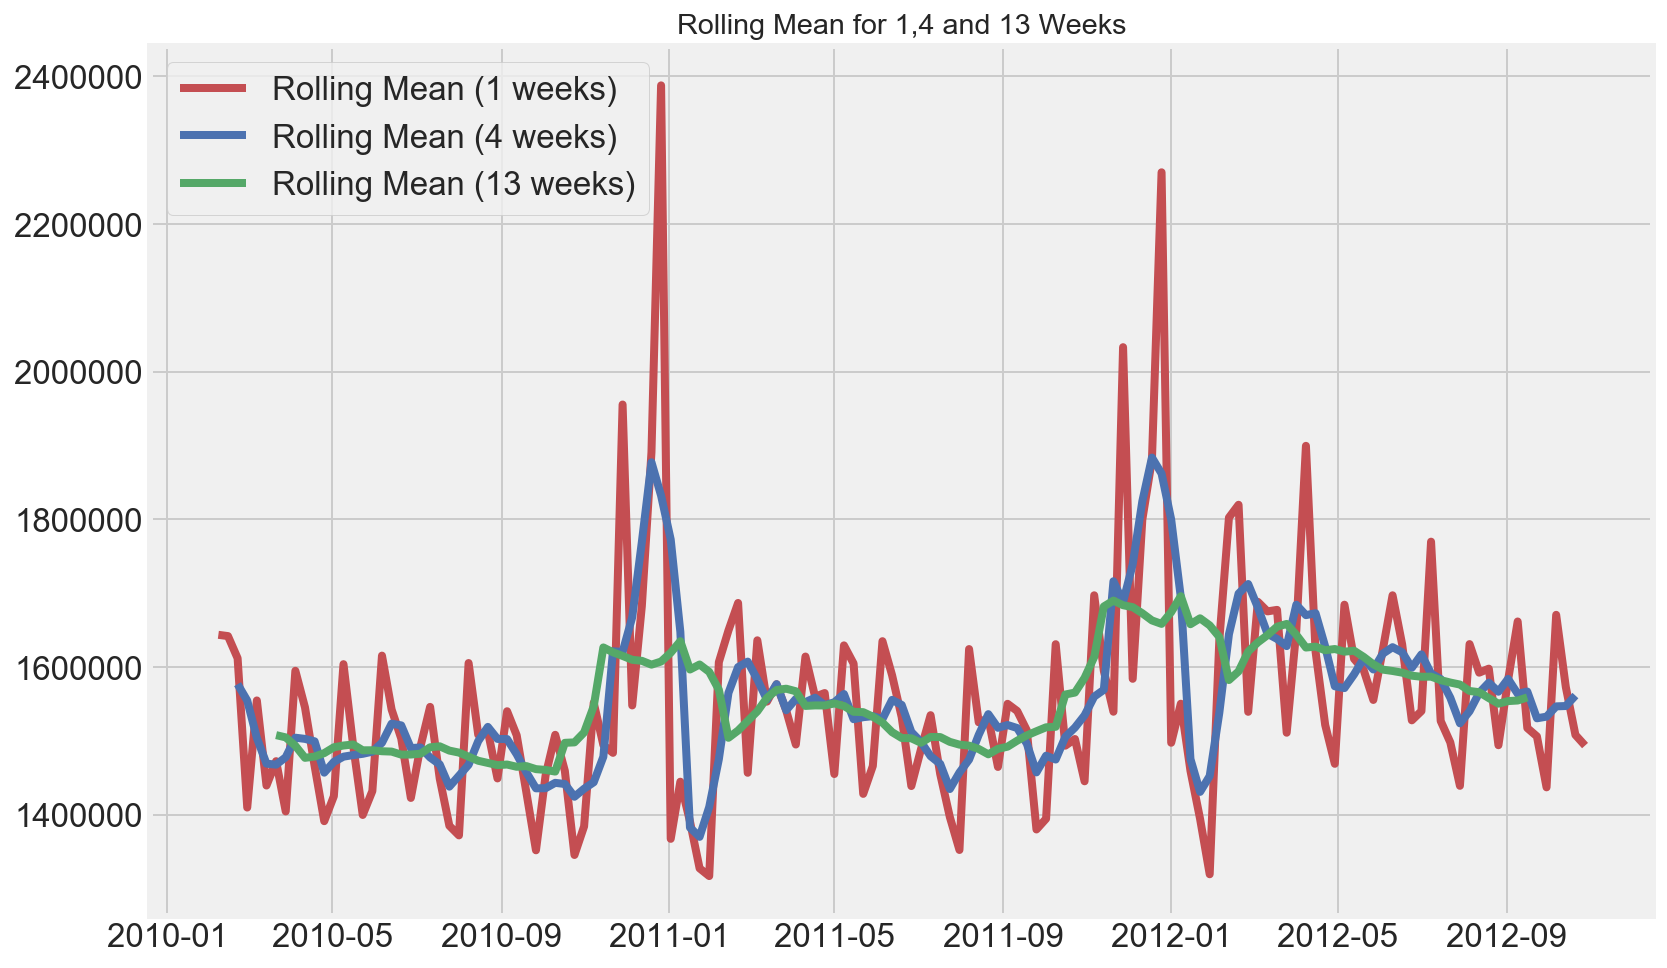

In [10]:
rolmean = {}
for i in [1, 4, 13]:
    key = str(i)+'W'
    rolmean[i] = store1_sales.rolling(window=i, center=True).mean()

colors = ['r', 'b', 'g']
plt.figure(figsize=(12, 8))
for key, color in zip(list(rolmean.keys()), colors):
    plt.plot(rolmean[key], color=color,
             label='Rolling Mean ({} weeks)'.format(key))

plt.legend(loc='best')
plt.title('Rolling Mean for 1,4 and 13 Weeks')
plt.show()

There are clearly spikes in the early year around January and February.  Most likely the result of huge increases for holiday spending in November and December.

These spikes are followed by sharp falls which could indicate either that there is a leading up and sudden drop off before and then after the holidays or there is a significant decrease in spending immediately following the holiday season.

You can choose to plot 1, 4 and 13 weeks, because those represent week to week as a default for comparison, 4 weeks is about a month and 13 weeks is a season (3 months).

### 3. Compute the 1, 2, 52 autocorrelations for Weekly_Sales and create an autocorrelation and partial autocorrelation plot.
<a id='acf'></a>

In [11]:
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [12]:
autocorrelations = acf(store1_sales.Weekly_Sales, nlags=60)

for i in [1, 2, 52]:
    print('{} Week Lag AutoCorr'.format(i), autocorrelations[i])

1 Week Lag AutoCorr 0.3016356562219121
2 Week Lag AutoCorr 0.12697451440761223
52 Week Lag AutoCorr 0.4430352476917247


In [13]:
def autocorr_plots(y, lags=None):
    figure, ax = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)
    plot_acf(y, lags=lags, ax=ax[0])
    plot_pacf(y, lags=lags, ax=ax[1])
    plt.show()

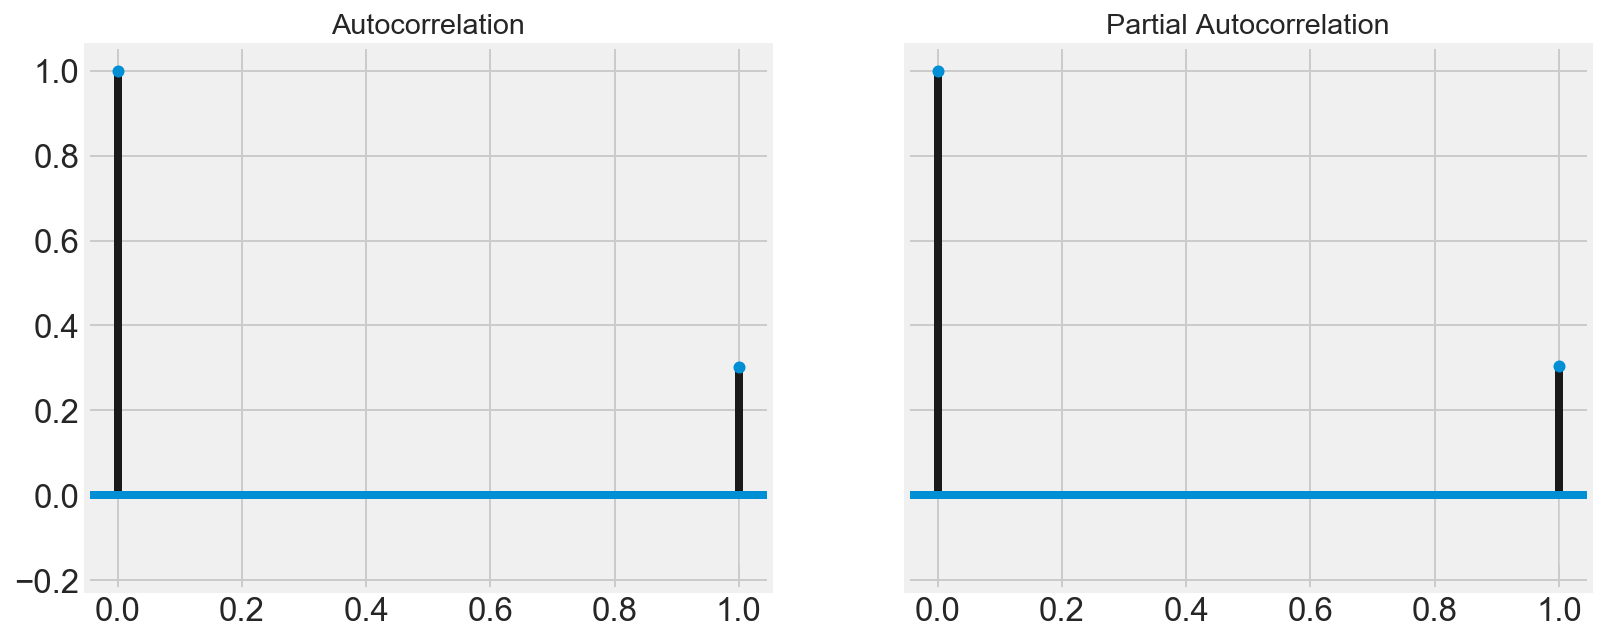

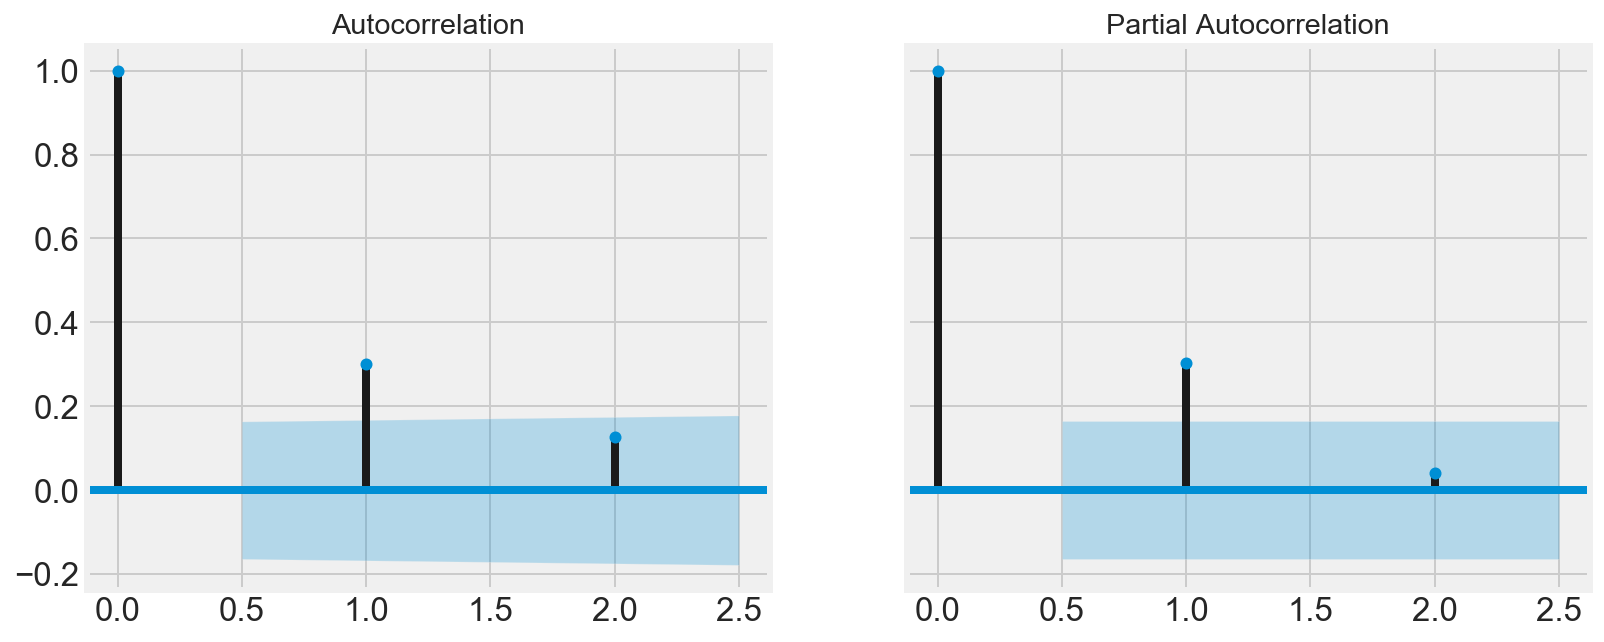

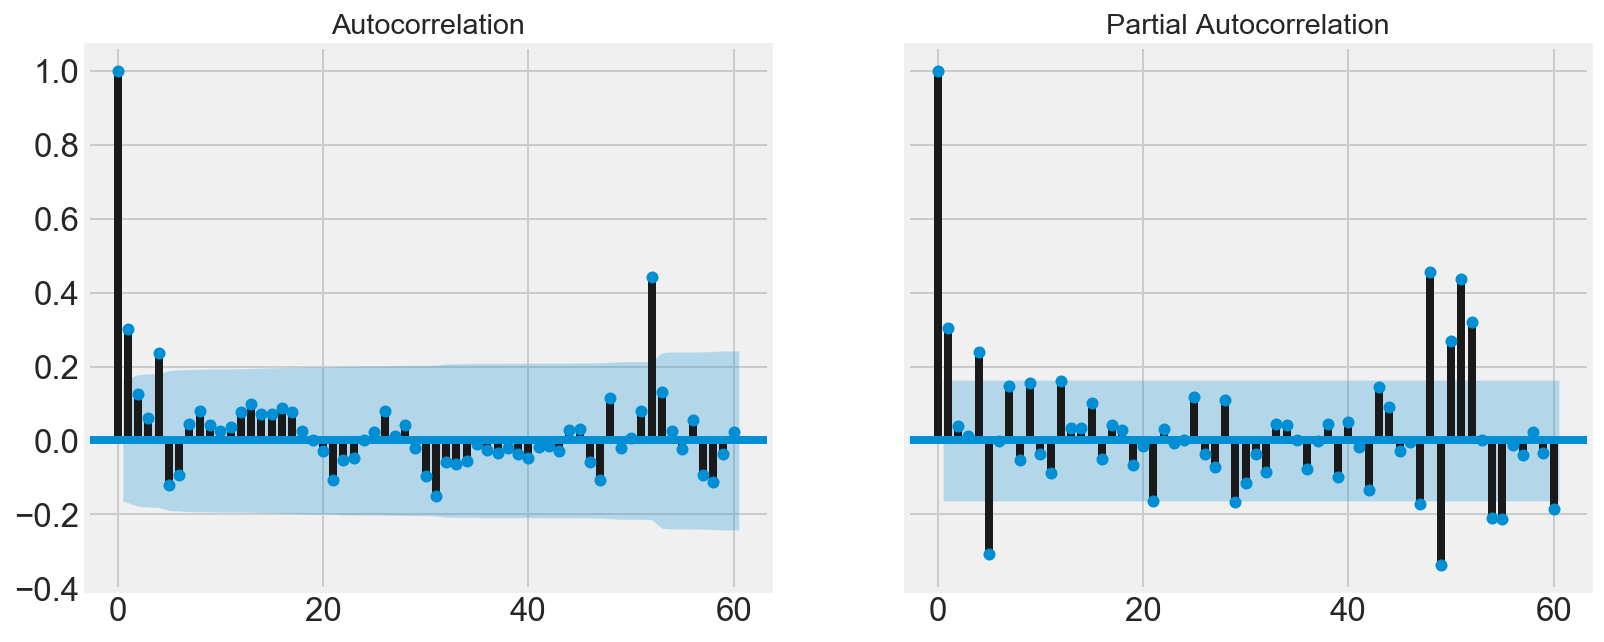

In [14]:
autocorr_plots(store1_sales, lags=1)
autocorr_plots(store1_sales, lags=2)
autocorr_plots(store1_sales, lags=60)

### 4. BONUS: What do the acf and pacf plots say about the type of model you want to build?
<a id='interpretation'></a>

The filled blue space indicates the 95% confidence interval.  The points inside the blue space are likely to be noise and do not imply any valuable correlation.  With the default 95% confidence interval we can expect that 5% of observations could fall outside this boundary, and those that do are the ones we should consider for further investigation about correlation.

- Lag 0: Apparently, the point at lag 0 has a high correlation (1.0). Why?
- Lag 1: Indicates some correlation between consecutive weeks.
- Lag 2: No significant correlation.
- Lag 4: There seems to be a monthly effect.
- Lag 5: A 5 week negative correlation.
- Lag 48: 11 months difference - compare to one month difference.
- Lag 51: 51 weeks difference - compare to one week difference.
- Lag 52: Annual seasonality.

### 5. Split the weekly sales data in a training and test set - using 75% of the data for training.
<a id='train-test'></a>

In [15]:
store1_sales.shape

(143, 1)

In [16]:
# shape of dataframe is 143 rows.
143*0.75
# first 107 rows for training, next 36 rows for testing?

107.25

In [17]:
train = store1_sales.head(int(3/4.*len(store1_sales)))
test = store1_sales.tail(len(store1_sales)-int(3/4.*len(store1_sales)))

### 6. "Difference" the data by converting the sales into change in sales 
<a id='diff'></a>


In [18]:
store1_sales['Weekly_Sales'].diff().head()

2010-02-07          NaN
2010-02-14     -1733.46
2010-02-21    -29989.27
2010-02-28   -202240.58
2010-03-07    145079.09
Freq: W-SUN, Name: Weekly_Sales, dtype: float64

In [19]:
store1_sales.std()

Weekly_Sales    155980.767761
dtype: float64

<a id='AR1'></a>
### 7. Fit an AR(1) model on the training data and compute the root mean squared error of the predictions. 
####    How effective is this model?

In [20]:
train.head()

,Weekly_Sales
2010-02-07,1643690.90
2010-02-14,1641957.44
2010-02-21,1611968.17
2010-02-28,1409727.59
2010-03-07,1554806.68


In [21]:
from statsmodels.tsa.arima_model import ARMA, ARIMA

train_values = train['Weekly_Sales']
train_dates = train.index

AR1 = ARMA(endog=train_values, dates=train_dates, order=(1, 0)).fit()


AR1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: ARMA
===================================================================================
Model:                   ARMA                  BIC:                      2883.3453 
Dependent Variable:      Weekly_Sales          Log-Likelihood:           -1434.7   
Date:                    2019-11-20 17:26      Scale:                    1.0000    
No. Observations:        107                   Method:                   css-mle   
Df Model:                2                     Sample:                   02-07-2010
Df Residuals:            105                                             02-19-2012
Converged:               1.0000                S.D. of innovations:      160916.939
No. Iterations:          3.0000                HQIC:                     2878.577  
AIC:                     2875.3268                                                 
-----------------------------------------------------------------------------------
                      Coef.      Std.Err.     t    P>|t|     [0.025       0.975]   
-----------------------------------------------------------------------------------
const              1543767.5554 22604.9556 68.2933 0.0000 1499462.6566 1588072.4543
ar.L1.Weekly_Sales       0.3147     0.0926  3.3985 0.0010       0.1332       0.4961
-------------------------------------------------------------------------------------------------
                      Real                Imaginary               Modulus               Frequency
-------------------------------------------------------------------------------------------------
AR.1                 3.1779                  0.0000                3.1779                  0.0000
===================================================================================

"""

In [22]:
train.tail()

,Weekly_Sales
2012-01-22,1394393.84
2012-01-29,1319325.59
2012-02-05,1636339.65
2012-02-12,1802477.43
2012-02-19,1819870.00


In [23]:
test.head()

,Weekly_Sales
2012-02-26,1539387.83
2012-03-04,1688420.76
2012-03-11,1675431.16
2012-03-18,1677472.78
2012-03-25,1511068.07


In [24]:
test.index.dtype

dtype('<M8[ns]')

In [25]:
test_values = test['Weekly_Sales']
test_dates = test.index

# The AR Predict takes a start and and end date as values and not a list.
# Could use the index position alternatively.
start = '2012-02-26'
end = '2012-10-28'


AR1_pred = AR1.predict(start=start, end=end)

For the AR(1) model we can also use ARMA and ARIMA with specific parameters.

```python
model = ARMA(endog = VALUES, dates = DATES, order = (1,0) )
model = ARIMA(endog = VALUES, dates = DATES, order = (1,0,0) )
```

- ARMA Order is represented as (p,q)
- ARIMA Order is represented as (p,d,q)
> - p = AutoRegression
> - q = Moving Average
> - d = Differences 

In [26]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(test_values, AR1_pred)**0.5)

105397.31820703618


On average we're off about $105,000 a week in sales for the squared error. Considering our range is 1.4m - 1.7m, that is about a 6-7.5 percent error.

### 8. Plot the residuals - where are their significant errors?
<a id='residuals'></a>

In [27]:
AR1_residuals = AR1.resid  # test_values - AR1_pred

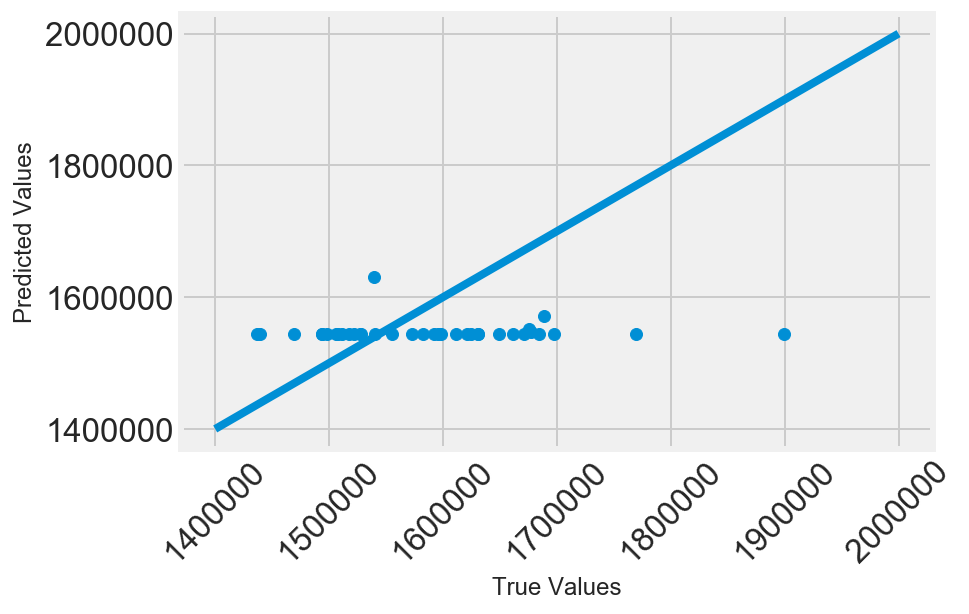

In [28]:
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.scatter(test_values, AR1_pred)
plt.plot([1.4*10**6, 2*10**6], [1.4*10**6, 2*10**6])
plt.xticks(rotation=45)
plt.show()

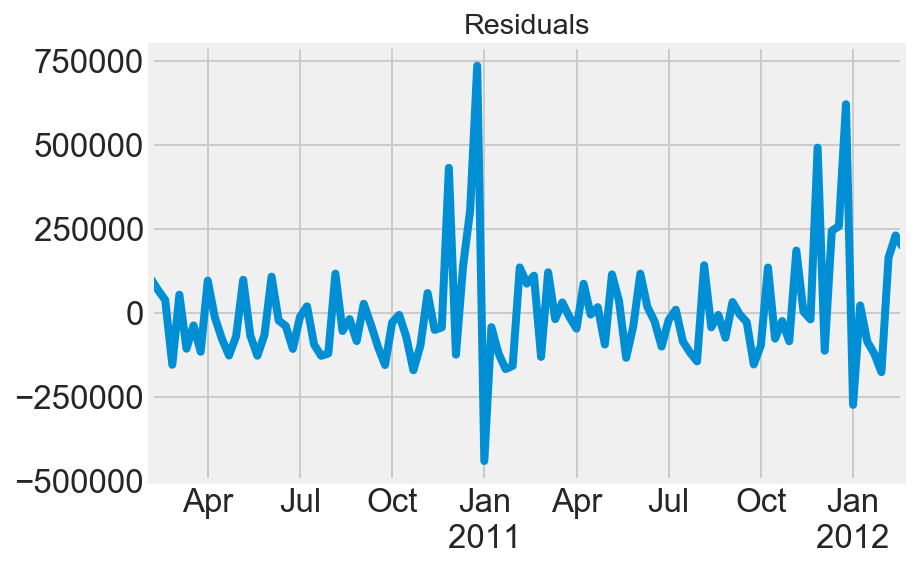

In [29]:
AR1_residuals.plot(title='Residuals')
plt.show()

Probably most significant errors would be those 2 major peaks in January.

### 9. Fit an AR(2) model and an ARMA(2, 2) model - does this improve your mean squared error on the held out set?
<a id='AR2'></a>

In [30]:
AR2 = ARMA(endog=train_values, dates=train_dates, order=(2, 0)).fit()

# Same start and end we outlined earlier.
AR2_pred = AR2.predict(start=start, end=end)

mean_squared_error(test_values, AR2_pred)**0.5

104559.43793925804

In [31]:
AR2_2 = ARMA(endog=train_values, dates=train_dates, order=(2, 2)).fit()

# Same start and end we outlined earlier.
AR2_2_pred = AR2_2.predict(start=start, end=end)

mean_squared_error(test_values, AR2_2_pred)**0.5

105083.44127994863

Looks like both of the errors were slightly better than the original AR, the error of the ARMA(2,2) was slightly worse than the ARMA(2,0) however.

### 10. Assemble your findings including any useful graphs.
<a id='summary'></a>

In [32]:
AR2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: ARMA
===================================================================================
Model:                   ARMA                  BIC:                      2887.6548 
Dependent Variable:      Weekly_Sales          Log-Likelihood:           -1434.5   
Date:                    2019-11-20 17:26      Scale:                    1.0000    
No. Observations:        107                   Method:                   css-mle   
Df Model:                3                     Sample:                   02-07-2010
Df Residuals:            104                                             02-19-2012
Converged:               1.0000                S.D. of innovations:      160638.038
No. Iterations:          5.0000                HQIC:                     2881.298  
AIC:                     2876.9635                                                 
-----------------------------------------------------------------------------------
                      Coef.      Std.Err.     t    P>|t|     [0.025       0.975]   
-----------------------------------------------------------------------------------
const              1543767.5554 23990.4243 64.3493 0.0000 1496747.1878 1590787.9231
ar.L1.Weekly_Sales       0.2974     0.0967  3.0747 0.0027       0.1078       0.4869
ar.L2.Weekly_Sales       0.0589     0.0976  0.6032 0.5477      -0.1324       0.2502
-------------------------------------------------------------------------------------------------
                      Real                Imaginary               Modulus               Frequency
-------------------------------------------------------------------------------------------------
AR.1                 2.3080                  0.0000                2.3080                  0.0000
AR.2                -7.3587                  0.0000                7.3587                  0.5000
===================================================================================

"""

In [33]:
AR2_2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: ARMA
====================================================================================
Model:                    ARMA                  BIC:                      2879.5997 
Dependent Variable:       Weekly_Sales          Log-Likelihood:           -1425.8   
Date:                     2019-11-20 17:26      Scale:                    1.0000    
No. Observations:         107                   Method:                   css-mle   
Df Model:                 5                     Sample:                   02-07-2010
Df Residuals:             102                                             02-19-2012
Converged:                1.0000                S.D. of innovations:      144106.759
No. Iterations:           23.0000               HQIC:                     2870.064  
AIC:                      2863.5627                                                 
------------------------------------------------------------------------------------
                      Coef.      Std.Err.     t     P>|t|     [0.025       0.975]   
------------------------------------------------------------------------------------
const              1543767.5555 19226.6741  80.2930 0.0000 1506083.9668 1581451.1443
ar.L1.Weekly_Sales      -1.0393     0.0897 -11.5822 0.0000      -1.2152      -0.8634
ar.L2.Weekly_Sales      -0.4696     0.0874  -5.3740 0.0000      -0.6409      -0.2983
ma.L1.Weekly_Sales       1.4691     0.0583  25.2002 0.0000       1.3549       1.5834
ma.L2.Weekly_Sales       0.9999     0.0745  13.4293 0.0000       0.8539       1.1458
--------------------------------------------------------------------------------------------------
                       Real                Imaginary               Modulus               Frequency
--------------------------------------------------------------------------------------------------
AR.1                 -1.1066                 -0.9513                1.4593                 -0.3870
AR.2                 -1.1066                  0.9513                1.4593                  0.3870
MA.1                 -0.7347                 -0.6785                1.0001                 -0.3813
MA.2                 -0.7347                  0.6785                1.0001                  0.3813
====================================================================================

"""

In [34]:
from scipy import stats


def residual_plot(res):
    resid_standard = (res-res.mean())/res.std()

    figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

    ax[0, 0].plot(res)
    ax[0, 0].axhline(res.mean(), color='grey')
    ax[0, 0].set_title('Residuals')
    plt.sca(ax[0, 0])
    plt.xticks(rotation=45)

    plot_acf(resid_standard, title='Correlogram', ax=ax[0, 1])

    sm.graphics.qqplot(res, line='45', fit=True, ax=ax[1, 0])
    ax[1, 0].set_title('Normal Q-Q')

    x = np.linspace(res.min(), res.max(), 1000)
    norm = stats.norm(loc=0, scale=res.std())
    sns.distplot(res, ax=ax[1, 1], label='kde estimate')
    ax[1, 1].plot(x, norm.pdf(x), label='normal distribution')
    ax[1, 1].legend()
    ax[1, 1].set_title('Distribution of Residuals')

    plt.show()

In [35]:
def ts_plot(model, init, end):
    fig, ax = plt.subplots(figsize=(12, 8))
    model.plot_predict(init, end, dynamic=False, plot_insample=True, ax=ax)
    ax.set_title(
        'In-sample predictions and out-of-sample forecasts', fontsize=24)
    plt.show()

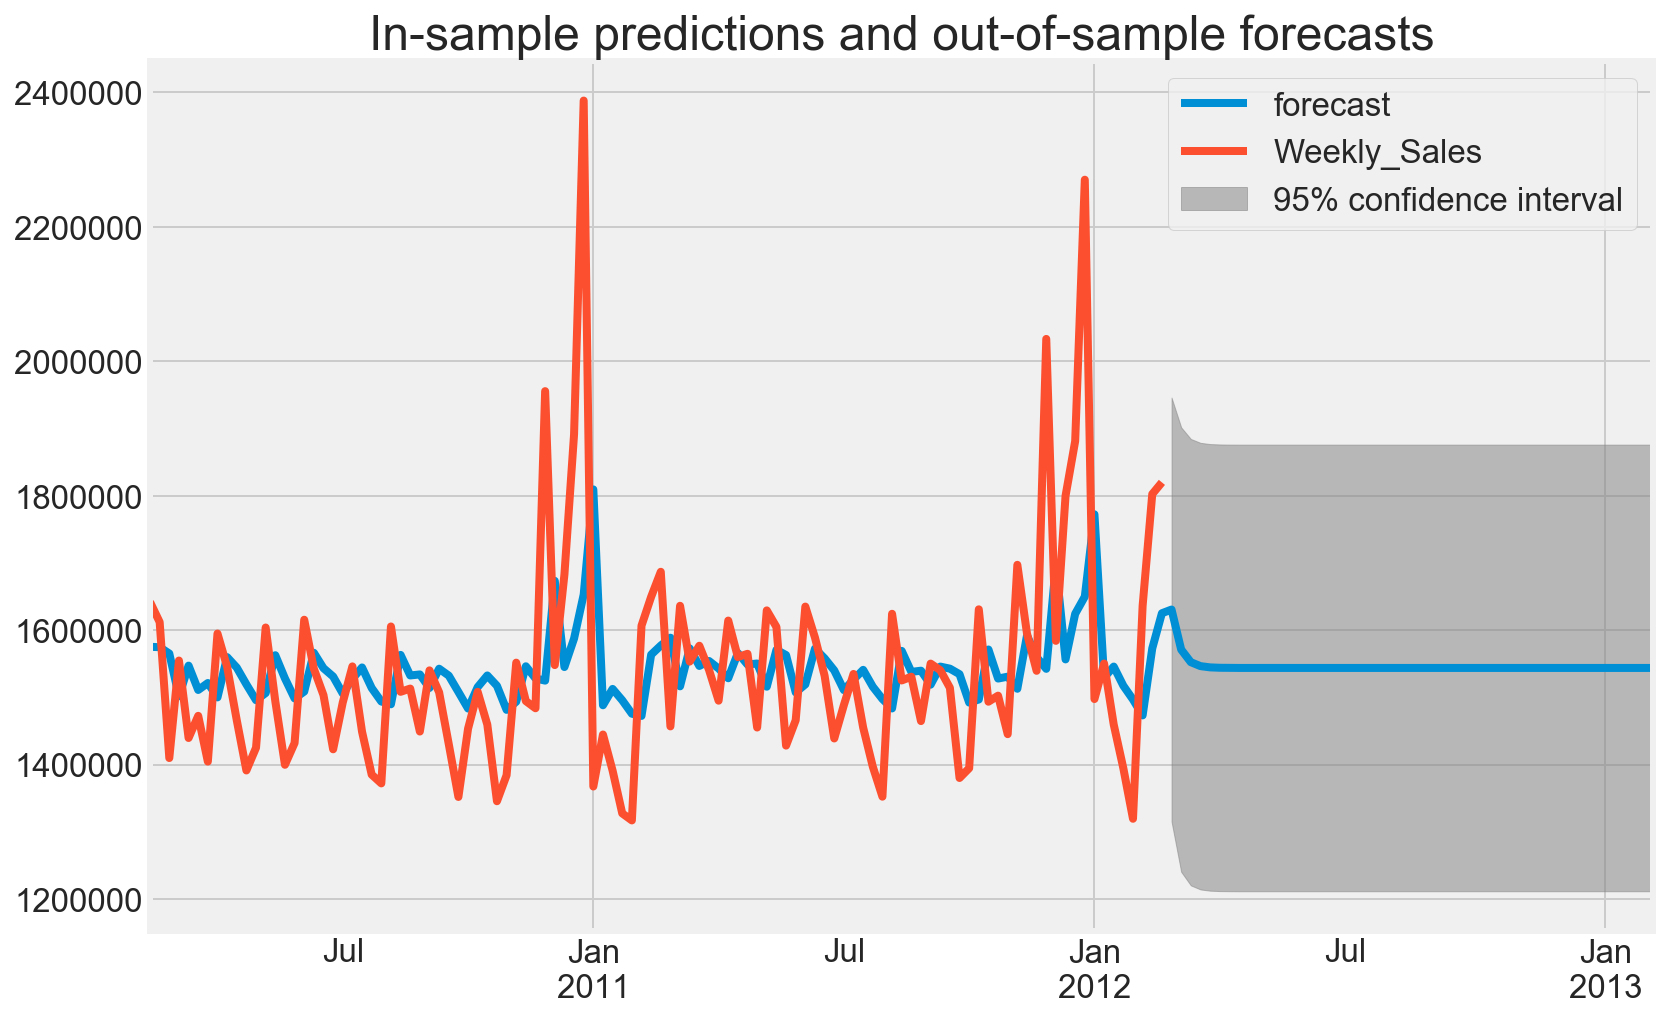

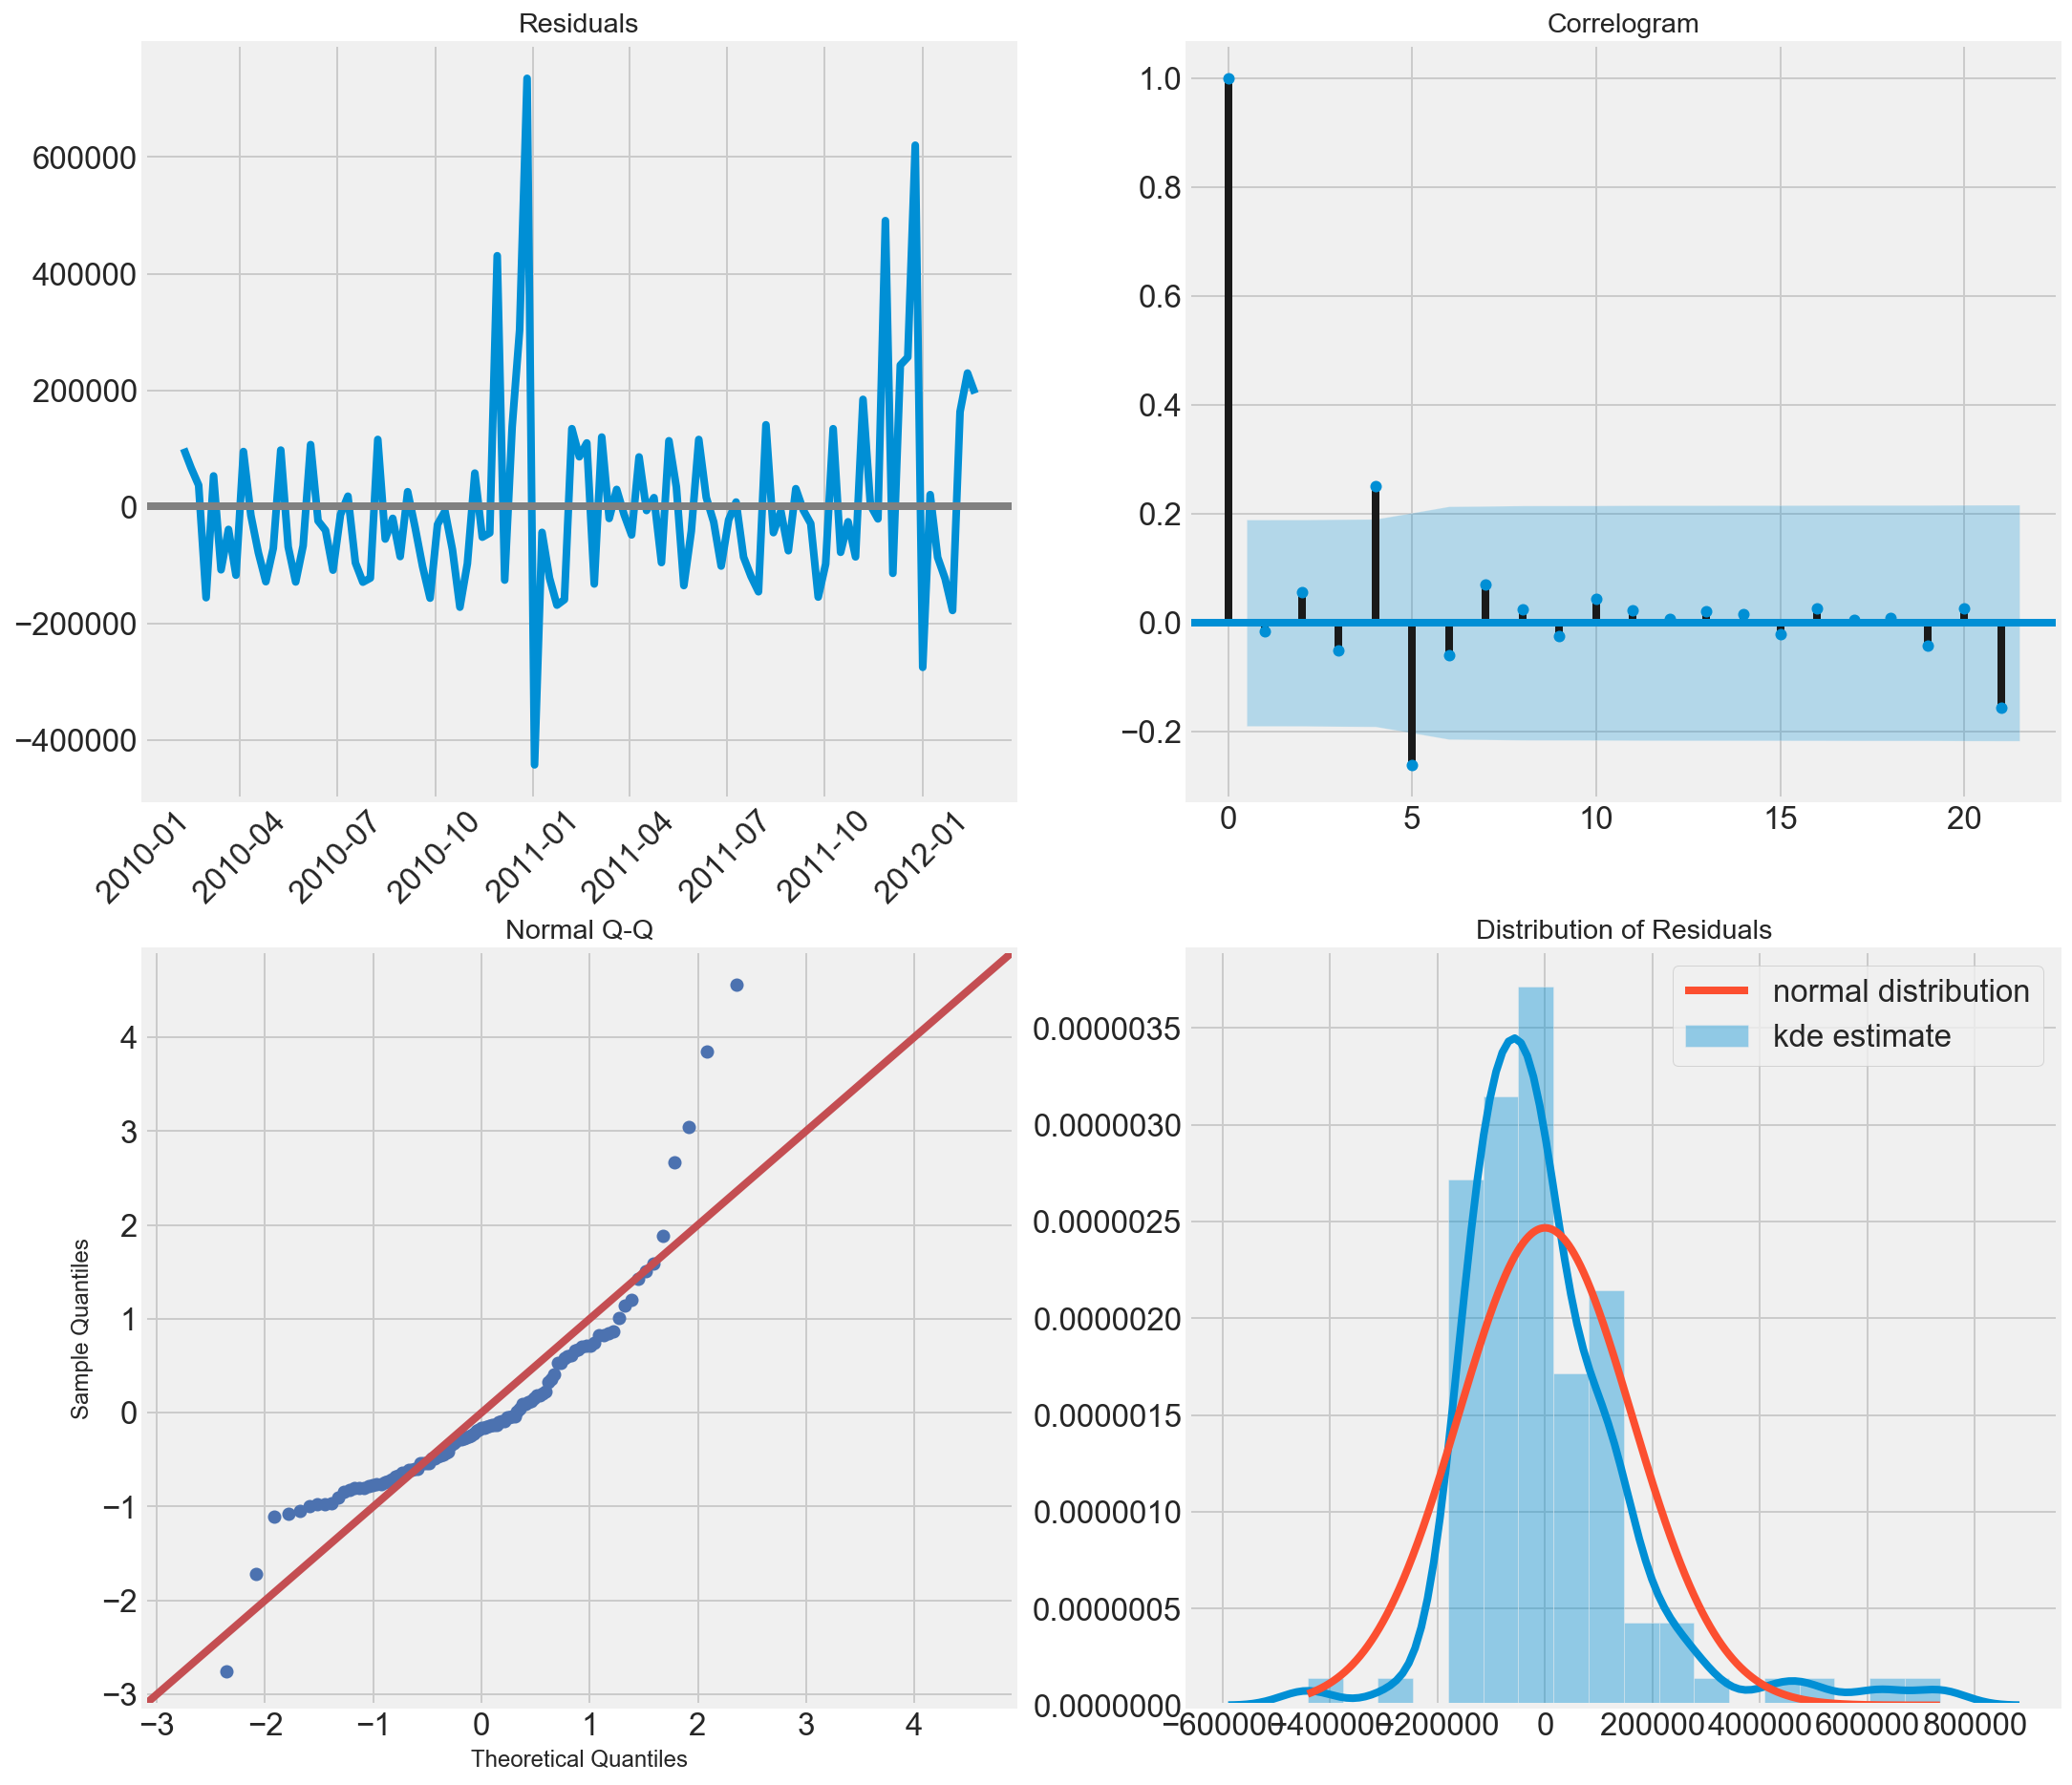

In [36]:
ts_plot(AR1, 1, len(train_values)+50)
residual_plot(AR1.resid)

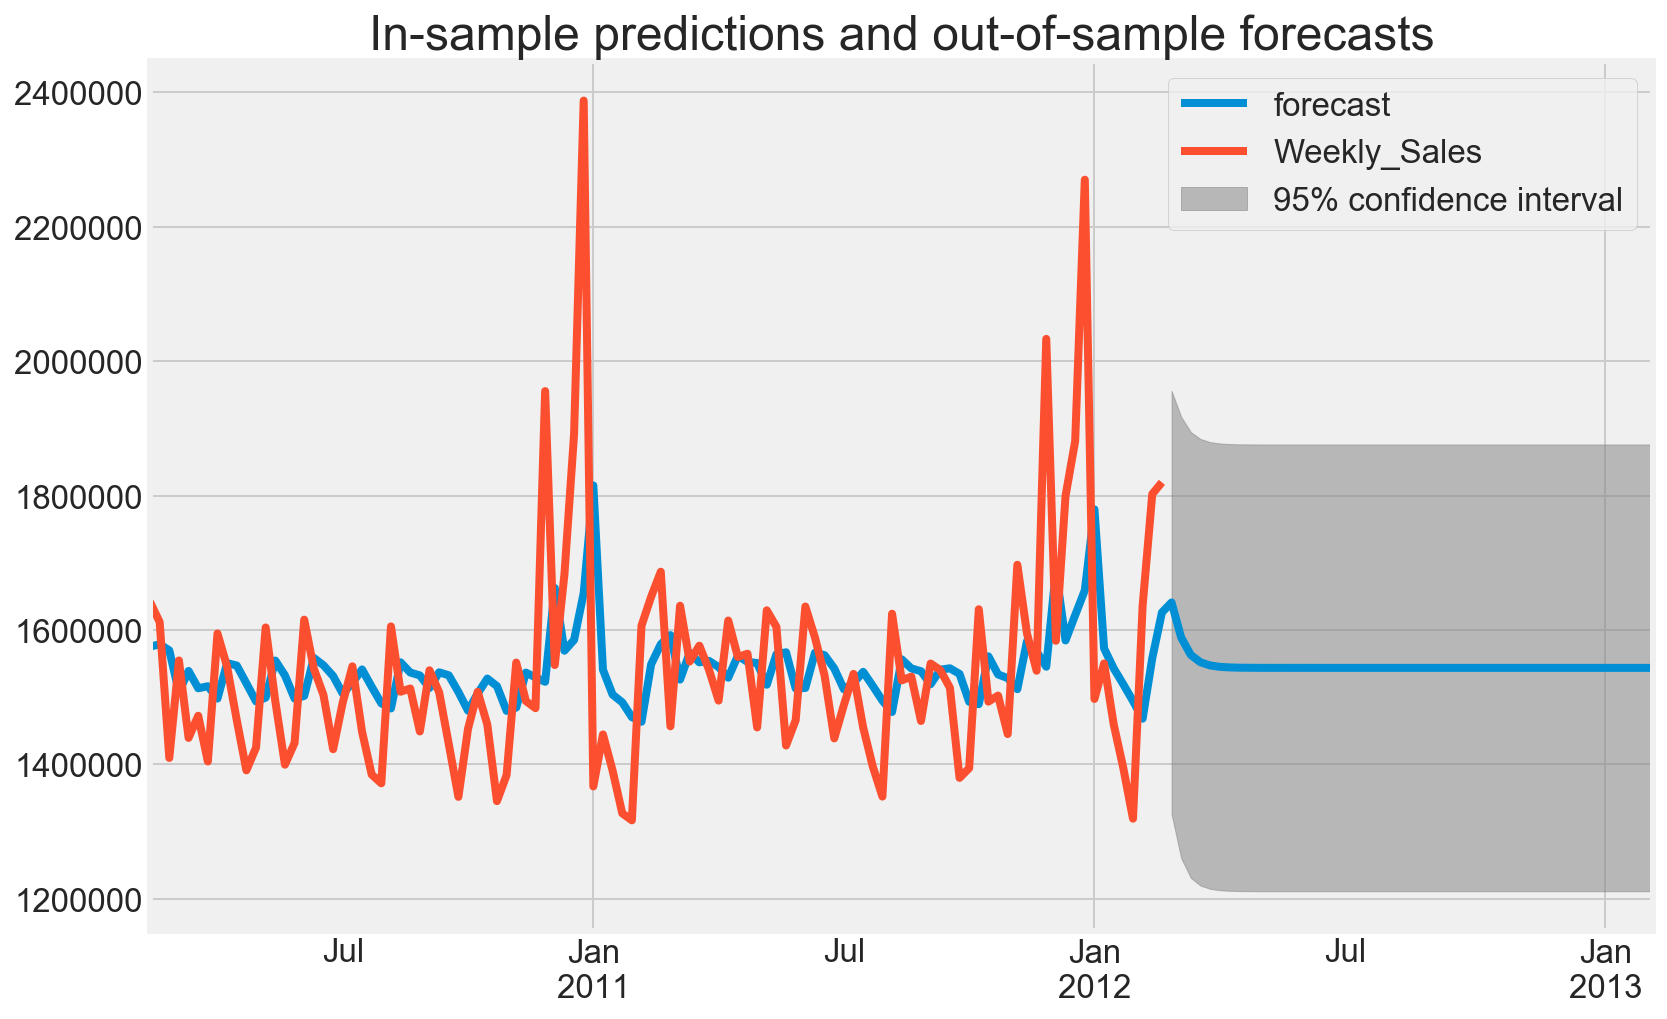

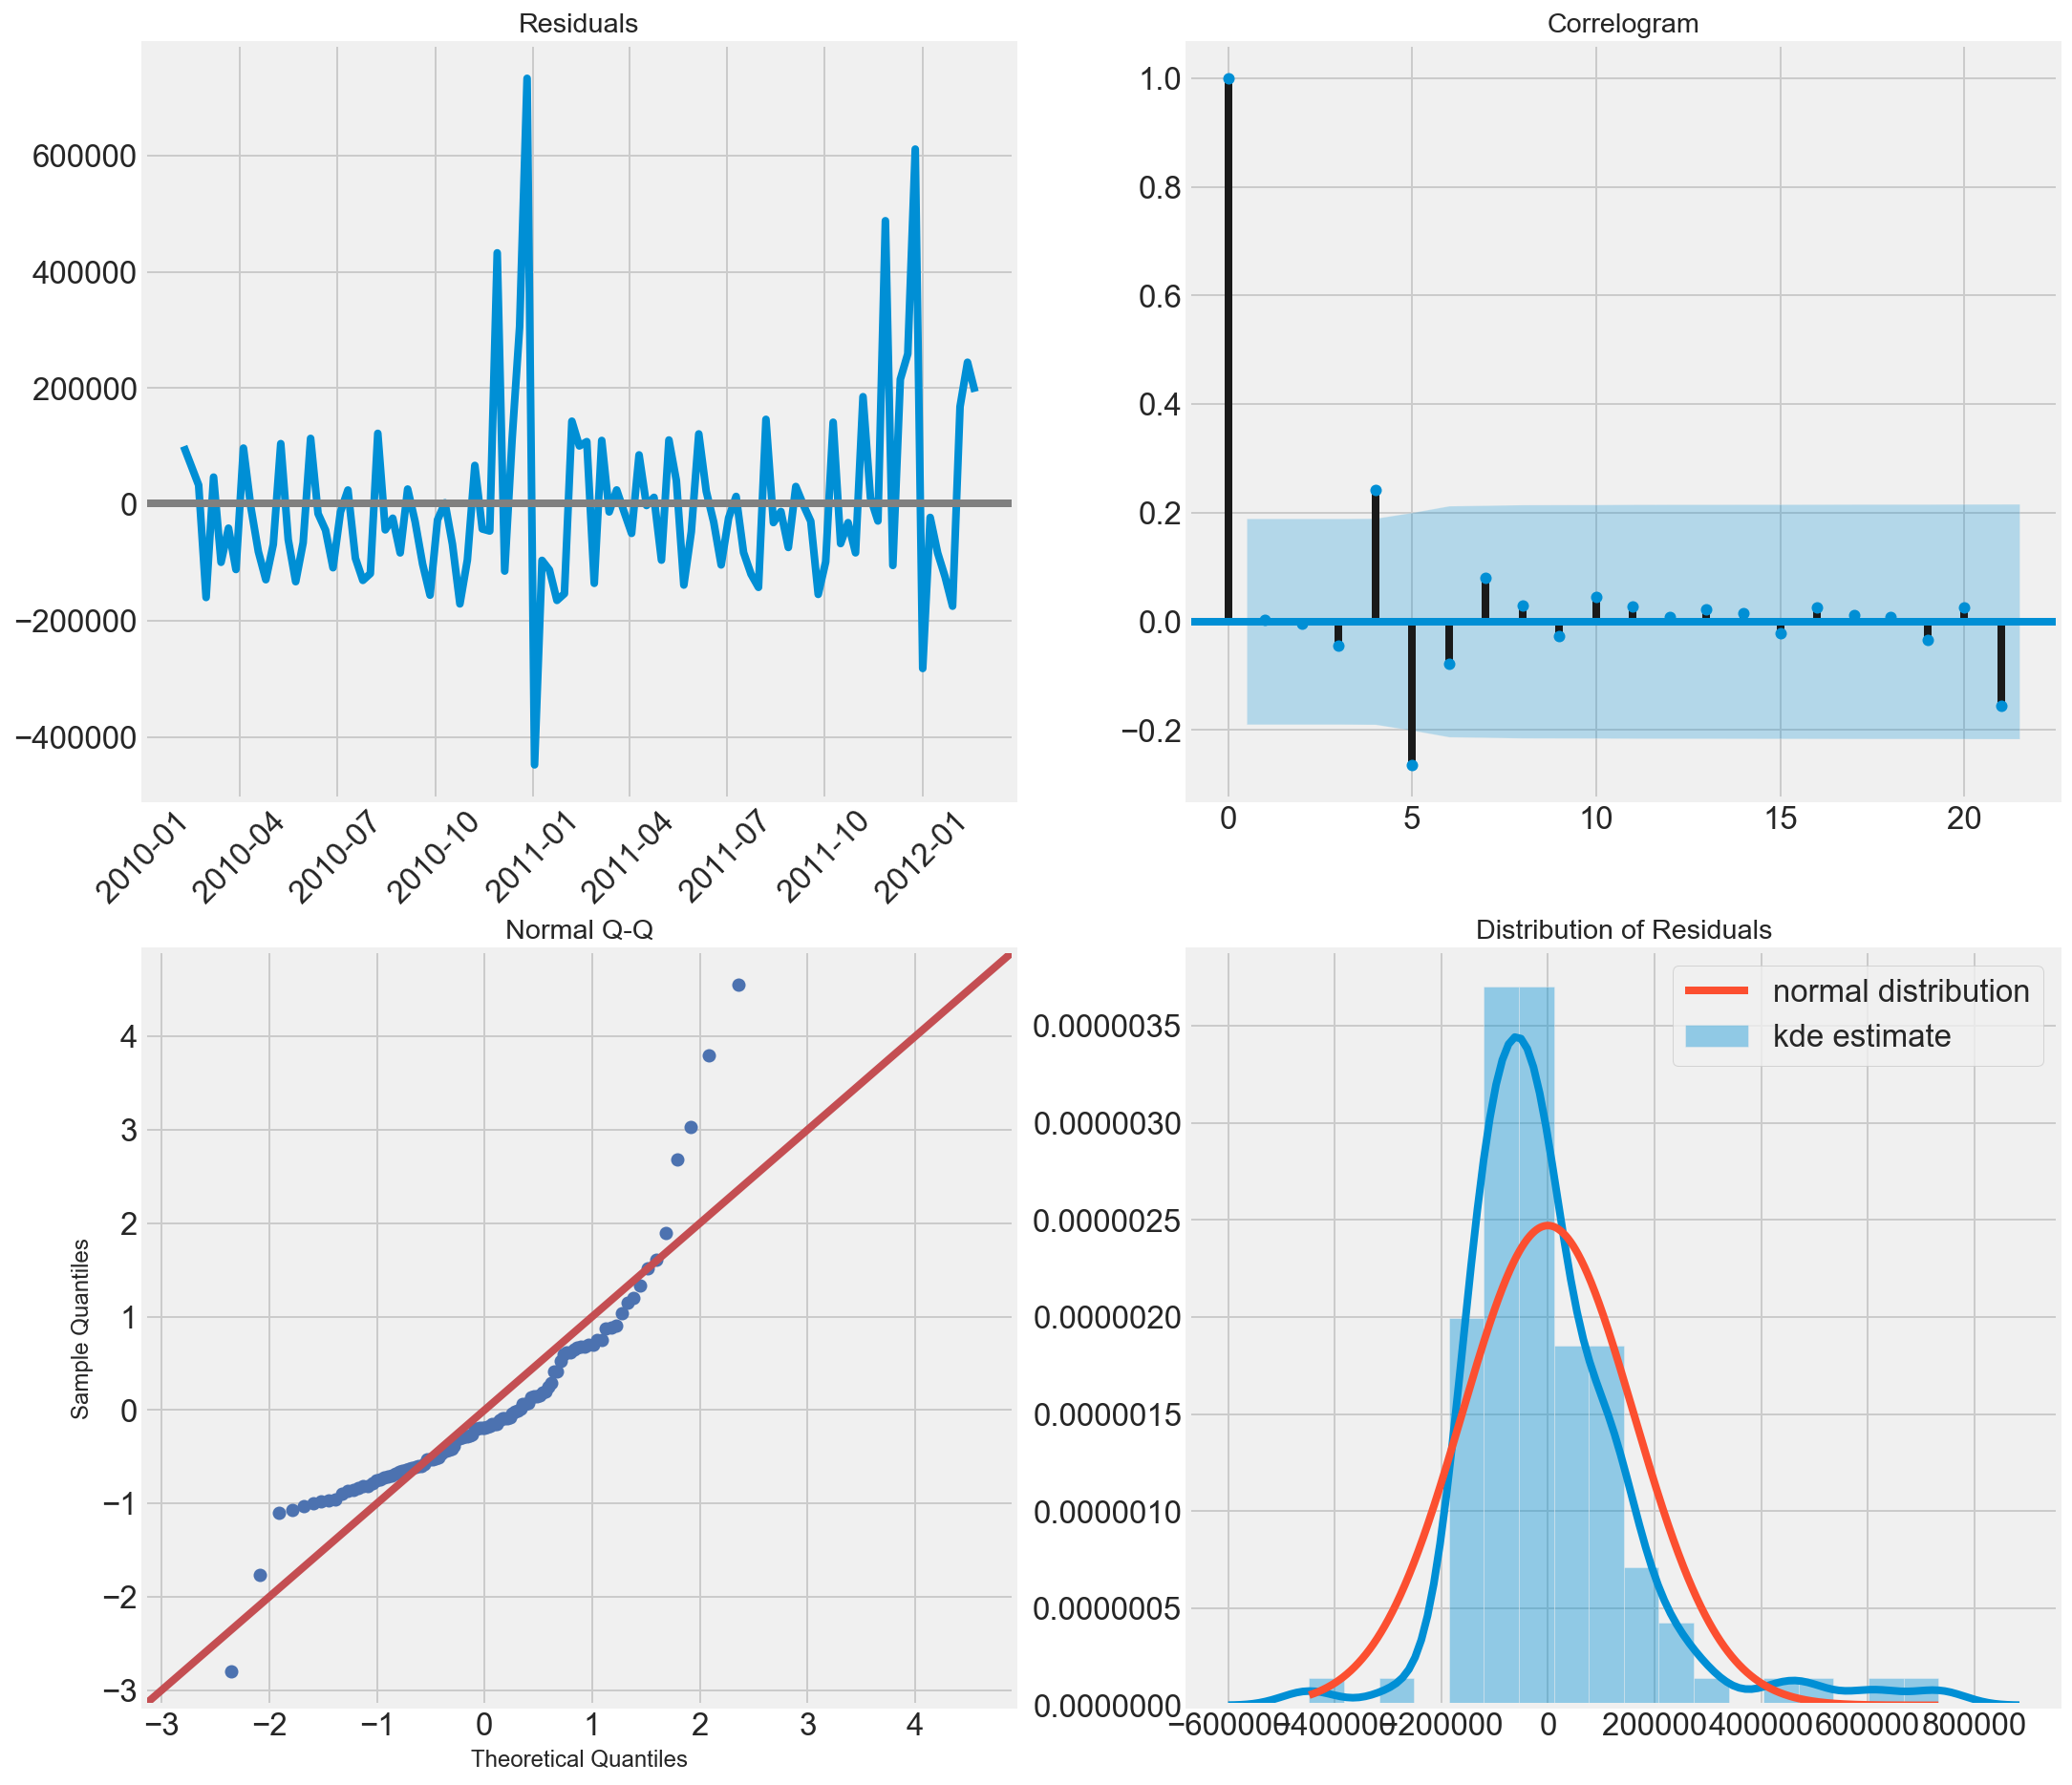

In [37]:
ts_plot(AR2, 1, len(train_values)+50)
residual_plot(AR2.resid)

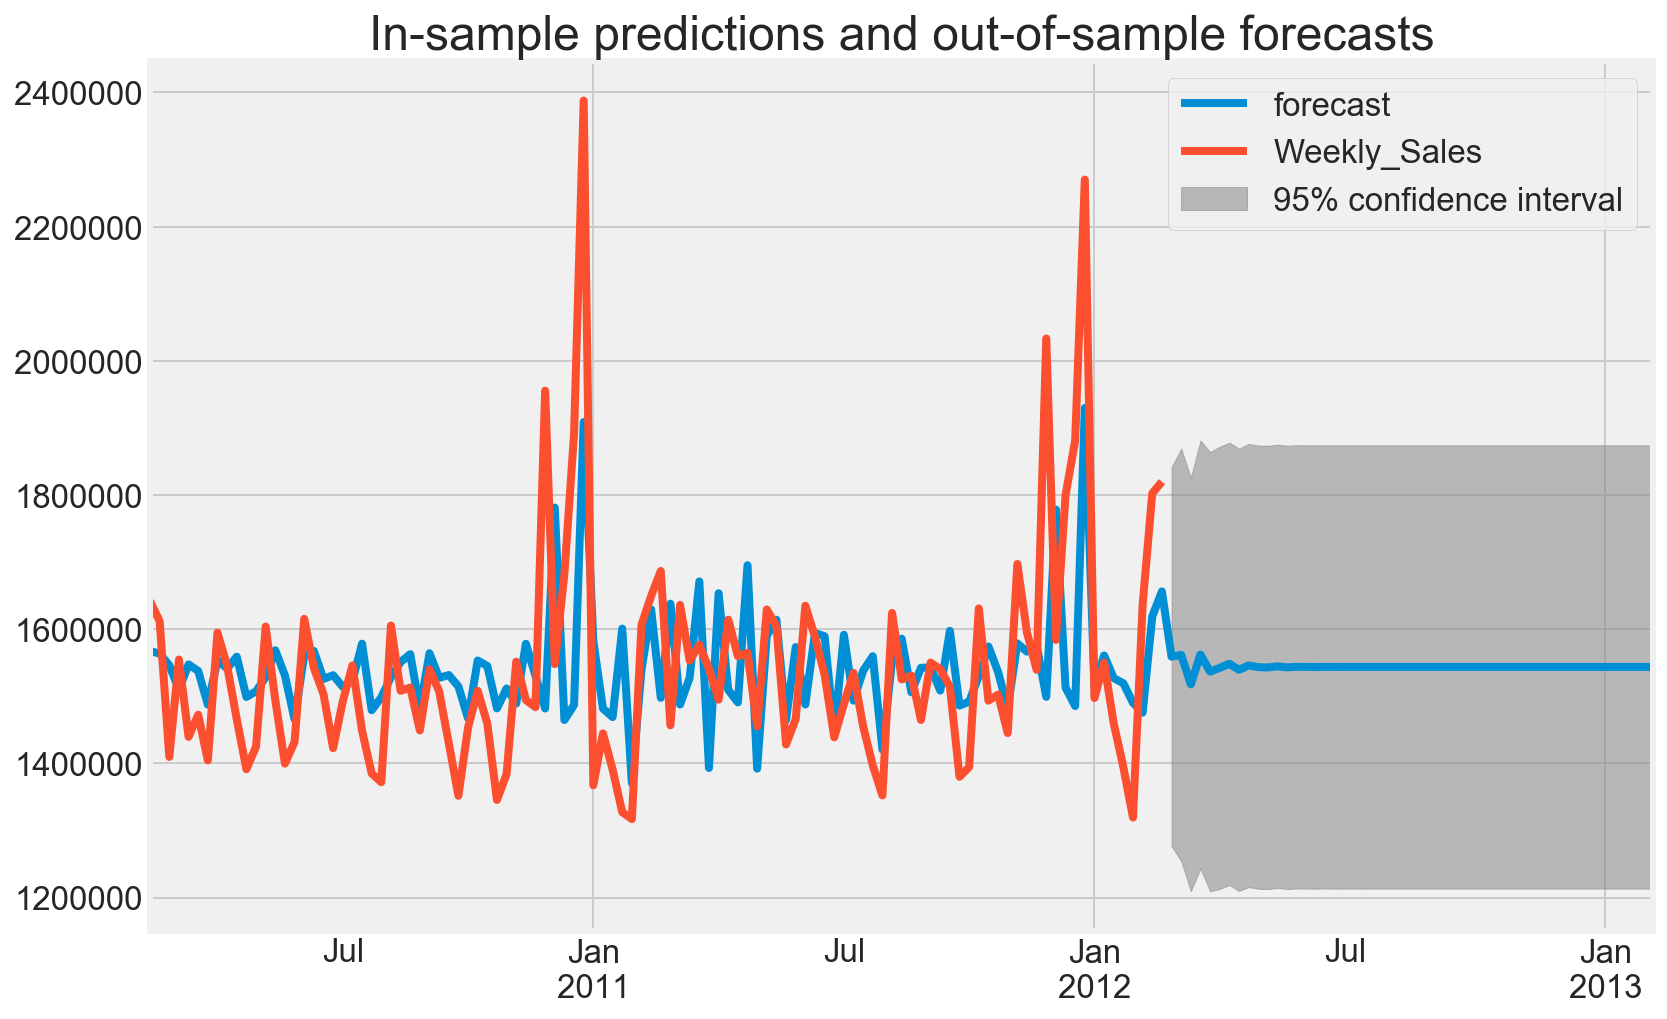

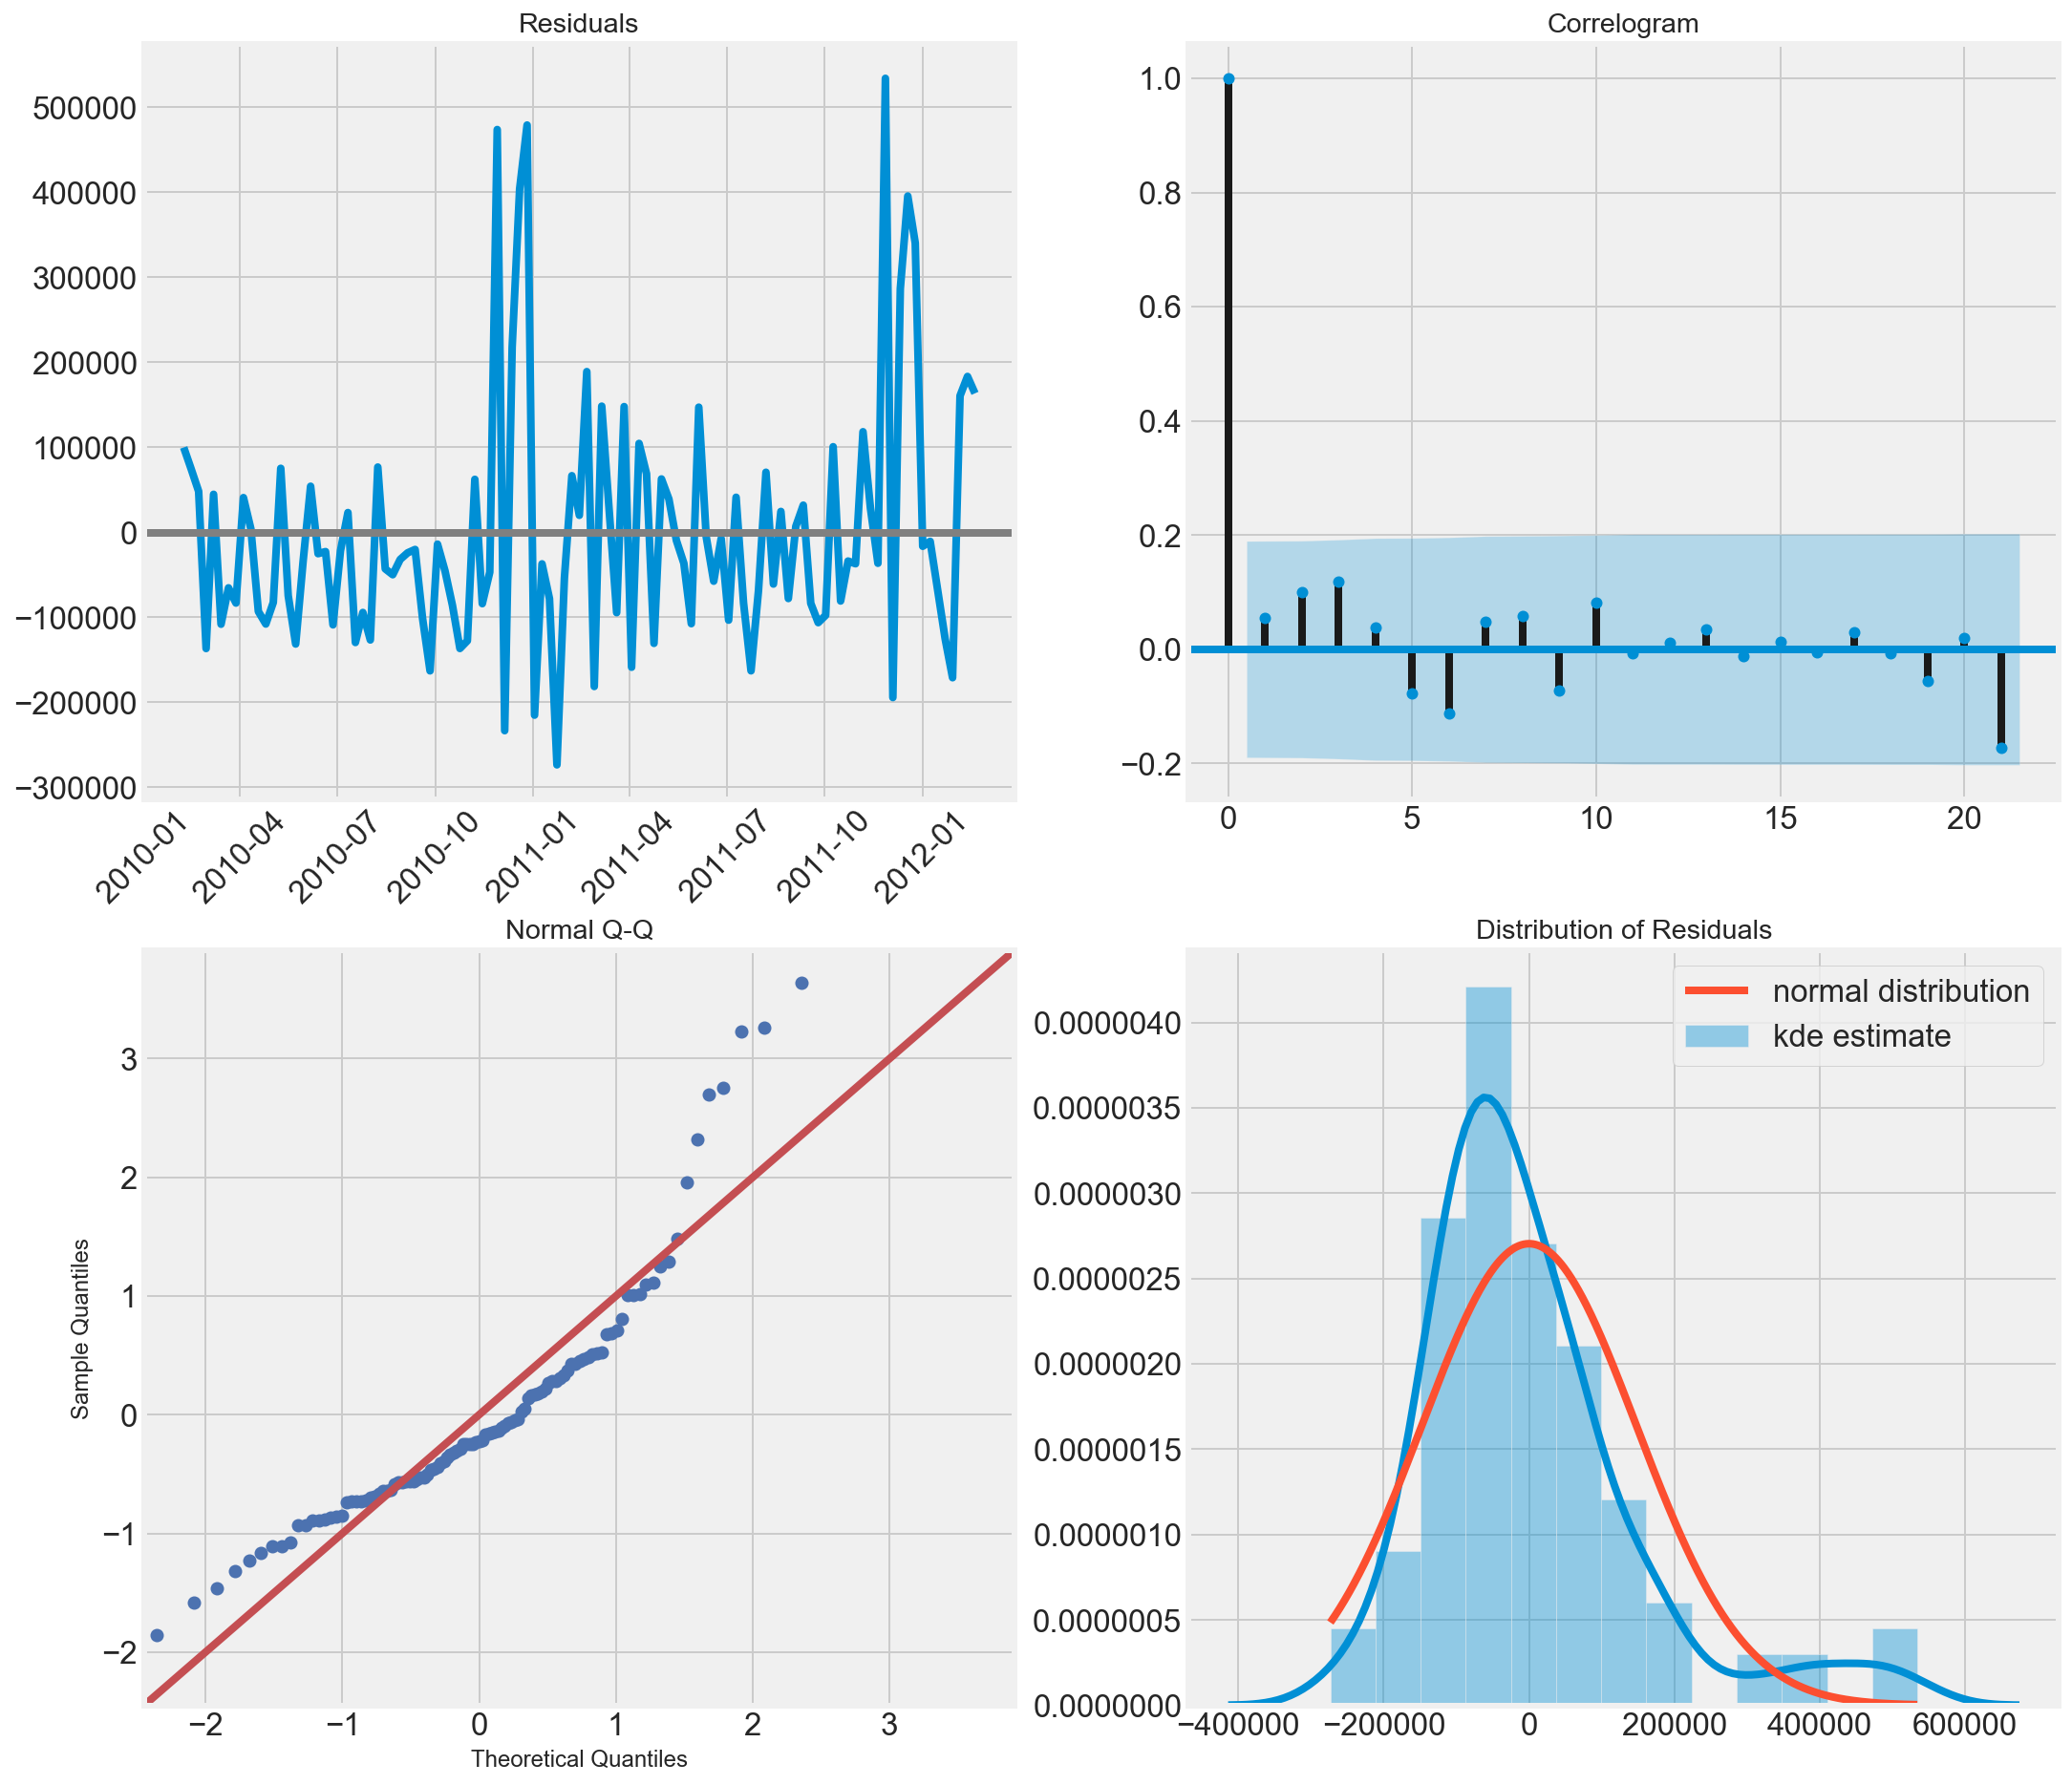

In [38]:
ts_plot(AR2_2, 1, len(train_values)+50)
residual_plot(AR2_2.resid)

{'aic':              0            1            2            3            4
0          NaN  3241.105333  3128.395542  3097.626593  3055.797237
1  2921.647336  2892.440666  2887.936696  2887.902463  2885.720481
2  2906.955566  2886.728110  2894.946686  2881.930589  2879.875130
3  2903.744963  2970.159335  2917.427648  2874.025174  2875.332515
4  2894.762214  2892.708720  2888.674784  2875.138022  2876.893366, 'bic':              0            1            2            3            4
0          NaN  3246.450991  3136.414028  3108.317909  3069.161382
1  2926.992994  2900.459153  2898.628011  2901.266607  2901.757454
2  2914.974052  2897.419425  2908.310830  2897.967562  2898.584932
3  2914.436278  2983.523479  2933.464621  2892.734975  2896.715146
4  2908.126359  2908.745693  2907.384585  2896.520653  2900.948825, 'aic_min_order': (3, 3), 'bic_min_order': (3, 3)}


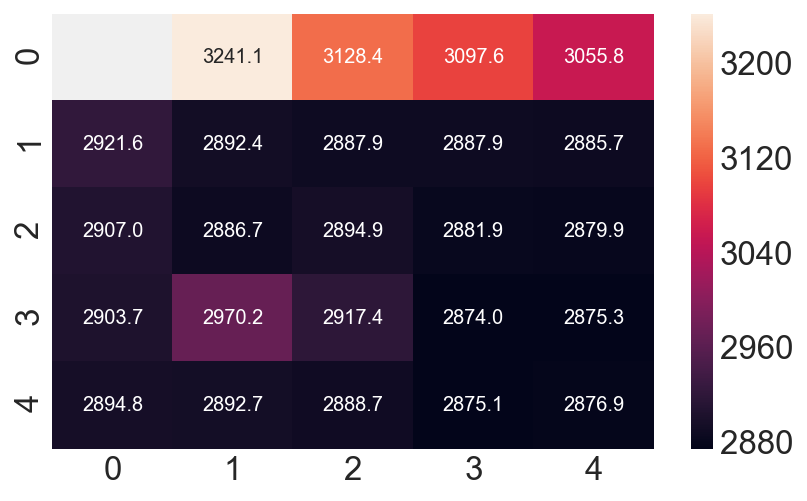

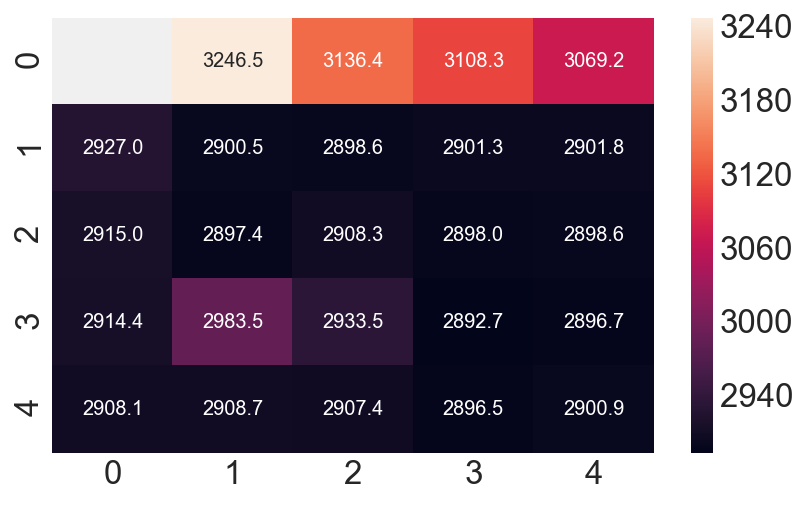

In [39]:
from statsmodels.tsa import stattools

auto_select = stattools.arma_order_select_ic(train_values,
                                             max_ar=4, max_ma=4, ic=['aic', 'bic'], trend='nc',
                                             fit_kw={'method': 'css-mle', 'solver': 'lbfgs', 'maxiter': 5000})

print(auto_select)

sns.heatmap(auto_select['aic'], annot=True, fmt='.1f')
plt.ylim([auto_select['aic'].shape[1], 0])
plt.show()

sns.heatmap(auto_select['bic'], annot=True, fmt='.1f')
plt.ylim([auto_select['bic'].shape[1], 0])
plt.show()

In [40]:
ARbest = ARMA(endog=train_values, dates=train_dates, order=(3, 3)).fit()

# Same start and end we outlined earlier.
ARbest_pred = ARbest.predict(start=start, end=end)

mean_squared_error(test_values, ARbest_pred)**0.5

102791.83910041928

0 0 nan
0 1 2402538229680.312
0 2 2345717135795.9883
0 3 2294337355320.567
0 4 2259770882670.5605
1 0 69779240461.36507
1 1 44378739783.724396
1 2 48150966883.92097
1 3 59860265919.311424
1 4 52598215510.68163
2 0 55985718583.49154
2 1 58569722112.88114
2 2 46416306134.064354
2 3 55488237321.845894
2 4 49017433057.39038
3 0 47783113714.22531
3 1 65230963943.37827
3 2 230324163138.99182
3 3 56827457340.26752
3 4 47339638921.81144
4 0 44231362327.57424
4 1 44446647976.8502
4 2 47869135359.325935
4 3 43812275379.68701
4 4 46664464653.62924
(4, 3) 43812275379.68701


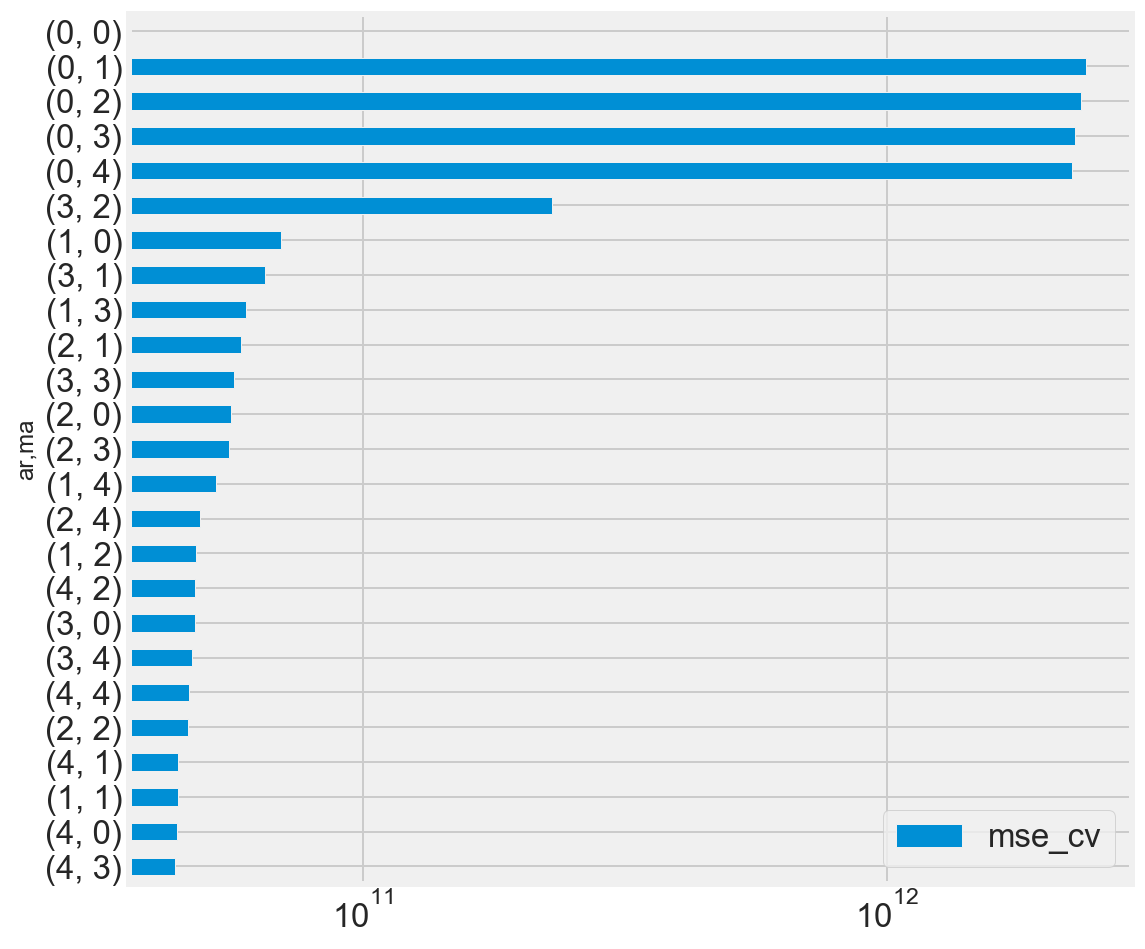

In [41]:
from sklearn.model_selection import TimeSeriesSplit

ts = TimeSeriesSplit(n_splits=3)
splits = [split for split in ts.split(train_values)]

best_order = (0, 0)
best_mse = 10**16
scores = []

for ar_order in range(5):
    for ma_order in range(5):
        try:
            mses = []
            for i in range(ts.n_splits):
                y_train = train_values.iloc[splits[i][0]]
                y_test = train_values.iloc[splits[i][1]]

                model_cv = ARMA(y_train, order=(ar_order, ma_order))
            
                result_cv = model_cv.fit(start_params=np.zeros(model_cv.k_ar+model_cv.k_ma),
                               solver='lbfgs', method='css', trend='nc')
                predictions_test = result_cv.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)
                mses.append(((y_test - (predictions_test))**2).mean())
                
            mse_mean = np.mean(mses)
            scores.append((model_cv.k_ar, model_cv.k_ma, mse_mean))
            print(model_cv.k_ar, model_cv.k_ma, mse_mean)
            if mse_mean < best_mse:
                best_mse = mse_mean
                best_order = (model_cv.k_ar, model_cv.k_ma)

        except:
                scores.append((model_cv.k_ar, model_cv.k_ma, np.nan))
                print(model_cv.k_ar, model_cv.k_ma, np.nan)
                
print(best_order, best_mse)

df_r = pd.DataFrame(scores, columns=['ar', 'ma', 'mse_cv'])
df_r.groupby(['ar', 'ma'])[['mse_cv']].max().sort_values(by='mse_cv').plot(kind='barh', figsize=(8, 8))
plt.xscale('log')
plt.show()